# Image Based Point Cloud Segmentation

Kefeng Huang timkhuang@icloud.com

## Packages

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
import pykitti
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from predict import predit_on_label
from evaluate import evaluate_sequence
from deepwv3plus_net import DeepWV3Plus, img_transform
from kitti_labels import city2kitti_translate, kitti_colorize
from dataset import generate_dataset, FeatureDB
from feature_net import FeatureNet

## Resources

This project is using the *Kitti Odometry* dataset for point cloud, images and 
calibration data and *SemanticKitti* for corresponding labels.

* *Kitti Odometry*: http://www.cvlibs.net/datasets/kitti/eval_odometry.php
* *SemanticKitti*: http://www.semantic-kitti.org/

DeepWV3Plus network is used to generate the image label or the image feature.
The code was adapted from NVIDIA/Semantic-Segmentation.
Pre-trained model for kitti downloaded from NVIDIA is also used.
* *NVIDIA/Semantic-Segmentation*: https://github.com/NVIDIA/semantic-segmentation/tree/sdcnet
* *kitti_best.pth*: https://drive.google.com/file/d/1OrTcqH_I3PHFiMlTTZJgBy8l_pladwtg/view?usp=sharing

In [2]:
## DATASET SETTINGS
seq = '06'
kitti_dataset_path = r'../kitti-dataset'
snapshot = r'./kitti_best.pth'

## LOAD DATASET
kitti_dataset = pykitti.odometry(kitti_dataset_path, sequence=seq)

## Segmentation based on Image Predicted Labels

The first part is directly using the labels predicted with 
*NVIDIA/Semantic-Segmentation* method using pre-trained *DeepWV3Plus* network
model *kitti_best.pth*. 

This part also tests different number of images to use and evaluates the 
different using the code adapted from *semanticKitti-api*. 

In [3]:
# Load Pretrained weights to the network
net = DeepWV3Plus()
net = torch.nn.DataParallel(net).cuda()
print('Net Built')

loaded_dict = torch.load(snapshot, map_location=torch.device('cpu'))
net.load_state_dict(loaded_dict['state_dict'])
net.eval()
print('Net restored')


Net Built
Net restored


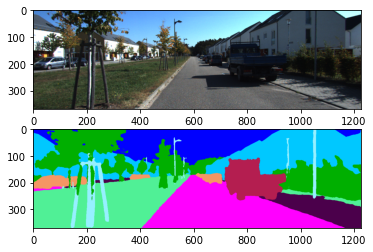

In [4]:
# Generate Random Image
sample_index = np.random.randint(len(kitti_dataset))
sample_img = kitti_dataset.get_cam2(sample_index)

# Generate Predictions
with torch.no_grad():
    img_tensor = img_transform(sample_img)
    pred = net(img_tensor.unsqueeze(0).cuda())
    pred = pred.cpu().numpy().squeeze()
    pred = np.argmax(pred, axis=0)

colored_pred = kitti_colorize(city2kitti_translate(pred))

# Draw the images
fig, axs = plt.subplots(2)
axs[0].imshow(sample_img)
axs[1].imshow(colored_pred)

In [5]:
velo_label_path = f'../kitti-dataset/sequences/{seq}/labels'

labels = []
for l in sorted(os.listdir(velo_label_path)):
    label = np.fromfile(os.path.join(velo_label_path, l), dtype=np.int32)
    labels.append(label)

print(len(labels))

1101


In [6]:
def predict_sequence_on_label(net, kitti, num_prev):
    predictions = []
    image_labels = deque(maxlen=num_prev)
    poses = deque(maxlen=num_prev)

    for idx, point in enumerate(kitti.velo):
        current_image = kitti.get_cam2(idx)
        with torch.no_grad():
            img_tensor = img_transform(current_image)
            pred = net(img_tensor.unsqueeze(0).cuda())
            pred = pred.cpu().numpy().squeeze()
            current_image_label= city2kitti_translate(np.argmax(pred, axis=0))
        
        current_pose = kitti.poses[idx]

        predictions.append(predit_on_label(
            point,
            current_image_label,
            current_pose,
            image_labels,
            poses,
            kitti.calib
        ))

        image_labels.append(current_image_label)
        poses.append(current_pose)
    
    return predictions

In [7]:
num_prev = 3

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

Inference takes 1607.61 seconds, which is 1.46 seconds per image
Mean Average Precision: 0.740447
Evaluation takes 354.35 seconds, which is 0.32 seconds per image


In [8]:
num_prev = 5

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

Inference takes 2276.99 seconds, which is 2.07 seconds per image
Mean Average Precision: 0.731010
Evaluation takes 343.54 seconds, which is 0.31 seconds per image


In [9]:
num_prev = 7

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

Inference takes 3004.55 seconds, which is 2.73 seconds per image
Mean Average Precision: 0.722302
Evaluation takes 360.98 seconds, which is 0.33 seconds per image


In [10]:
num_prev = 9

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

Inference takes 3761.06 seconds, which is 3.42 seconds per image
Mean Average Precision: 0.716746
Evaluation takes 357.26 seconds, which is 0.32 seconds per image


## Segmentation based on Image Features

### Create Dataset

The last layer in the DeepWV3Plus network is deleted in order to extract the
image feature instead of the final labels.
In order to train network based on the features from the image, we create a dataset
using the adapted network. In this dataset, the input value is 256 features and 
the label is the ground truth value of that point in semanticKitti.
The features are averaged from previous 3 frames.  

In [4]:
feature_dataset_path = r"../feature-dataset"

generate_dataset(
    ['01', '02', '03', '04', '05', '06'], 
    feature_dataset_path, 
    kitti_dataset_path, 
    snapshot,
    dataset_size=100000
)

Net Built
Net restored
20000 / 100000 data added.
Including [  785.   769.    36. 18410.] of different projections
40000 / 100000 data added.
Including [ 3417.  3095.    62. 33426.] of different projections
60000 / 100000 data added.
Including [ 9285.  7833.   116. 42766.] of different projections
80000 / 100000 data added.
Including [10847.  9480.   116. 59557.] of different projections
100000 / 100000 data added.
Including [15172. 12726.   116. 71986.] of different projections
120000 / 100000 data added.
Including [20924. 18261.   116. 80699.] of different projections
120636 / 100000 data added.
Including [21559. 18262.   116. 80699.] of different projections


In [3]:
feature_dataset_path = r"../feature-dataset"
loss_function = nn.CrossEntropyLoss()

In [4]:
feature_dataset = FeatureDB(feature_dataset_path)
feature_net = FeatureNet().cuda()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

batch_size = 128
learning_rate = 0.01
epochs = 100

data_loader = DataLoader(
    feature_dataset,
    batch_size=batch_size,
    shuffle=True
)
optimizer = optim.Adam(feature_net.parameters(), lr=learning_rate)

losses = []

for e in range(epochs):
    epoch_loss = 0.0

    for _, data in enumerate(data_loader):
        input, target = data
        input, target = input.cuda(), target.cuda()

        optimizer.zero_grad()
        pred = feature_net(input)

        loss = loss_function(pred, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(data_loader)
    losses.append(epoch_loss)

    if (e % 20 == 0):    
        print('Epoch ' + str(e) + ' : ' + str(epoch_loss))


plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses)

/opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [17,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.